<a href="https://colab.research.google.com/github/Many98/real_estate/blob/models/notebooks/XGboost_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 292 kB/s 


In [2]:
!pip uninstall xgboost
!pip install xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 36 kB/s 


In [ ]:
!pip install gpboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 8.8 MB/s 


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
#from gpboost import GPBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from category_encoders import TargetEncoder
from xgboost import plot_importance
#from gpboost import plot_importance as gp_importance
#utils
from functools import partial

In [59]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('test_dataset.csv', sep=',', delimiter=None, encoding="utf8")
df2 = pd.read_csv('dataset.csv',sep=',', delimiter=None, encoding="utf8")

df.drop(columns=df.columns[0], axis=1, inplace=True) 

ok_cols = df.columns.difference(["note", "description", "hash", "name", "desc_hash", 
                                 "floor_area", "geometry", "place" ,"tags",
                                 "additional_disposition", "transport","header",
                                 "date"]+ [i for i in df.columns if '_txt' in i])

df = df[ok_cols]

df['price_m2'] = df["price"]/df["usable_area"]
df['gp'] = df['gp_mean_price'] * df["usable_area"]
df['price_diff'] = df['gp'] - df['price']
df['price_diff_m2'] = df['gp_mean_price'] - df['price_m2']

df = df[(df.price_m2 > 40000) & (df.price_m2 < 380000)]
df = df[(df.floor > -2) & (df.floor < 30)]


df2['price_m2'] = df2["price"]/df2["usable_area"]


df2 = df2[(df2.price_m2 > 40000) & (df2.price_m2 < 380000)]
df2 = df2[(df2.floor > -2) & (df2.floor < 30)]

for i in only_ord_dist:
  df2[i] = df[i]

df['city_district'] = df2['city_district']

df.dropna(how='any',subset=['city_district'], inplace=True)
df2.dropna(how='any',subset=['city_district'], inplace=True)
 


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (367,385,388,389,391,392) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app

# Exploratory analysis insigths

- `noise` is not very good predictor (high correlation) 

- most of `dist` features are within few metres
 which makes them not very useful

- on the other hand `subway_dist`, `tram_dist`, `train_dist` have non-trivial distribution and therefore I suggest to use only them from `dist` features

- in dataset are some "outliers" e.g. to low price per m2 -> this should be filtered

In [ ]:
df2.groupby('disposition').describe()['price_m2']

,count,mean,std,min,25%,50%,75%,max
disposition,,,,,,,,
1+1,211.0,129391.523909,31100.831105,79761.904762,107565.359477,125641.025641,143270.440252,218181.818182
1+kk,1059.0,151211.178190,35135.052336,52368.421053,127454.069767,148455.500000,171428.571429,322008.571429
2+1,576.0,116164.839044,28588.779475,319.444444,98654.401154,110917.508418,127103.448276,288800.000000
2+kk,2218.0,135230.267671,34665.599951,37074.235808,111769.073966,130000.000000,154018.965517,402631.578947
3+1,867.0,104334.547072,27733.364807,5077.464789,86986.878183,97619.047619,112725.974462,307758.620690
3+kk,1589.0,129295.603673,31979.801692,438.596491,106533.333333,126906.360656,149456.521739,316952.380952
4+1,190.0,111754.124148,31425.615169,49038.461538,89637.962963,103399.339934,129383.161512,246679.577465
4+kk,586.0,132351.802274,37862.229163,37953.795380,104471.721091,130135.585659,155626.710081,272704.850467
5+1,30.0,119236.888812,25112.016948,82636.363636,103014.043528,114271.978022,131239.749574,186440.677966


In [ ]:
df2.groupby('city_district').describe()['price_m2']

,count,mean,std,min,25%,50%,75%,max
city_district,,,,,,,,
Praha 1,219.0,187112.095311,46469.164037,22912.790698,153237.519380,183947.368421,218519.447622,336170.212766
Praha 10,562.0,120931.256282,31432.941022,319.444444,98724.258369,114223.214286,136465.909091,217391.304348
Praha 11,308.0,117528.278534,30199.145879,59404.761905,94252.021563,109270.833333,138266.083333,221607.875000
Praha 12,295.0,113835.690761,23322.883406,57918.367347,96049.196787,109079.545455,132902.570520,174255.319149
Praha 13,330.0,120197.345375,33578.232791,55568.181818,95352.998066,113362.882800,144250.329545,223994.444444
Praha 14,226.0,111308.303747,24993.620579,49038.461538,94529.135338,107608.695652,129758.012821,193278.688525
Praha 15,453.0,138885.903453,32885.587556,47301.587302,112244.897959,147051.711864,163589.530612,205625.266667
Praha 16,14.0,123479.081471,16363.946009,93150.684932,113956.403949,127673.295163,132852.098631,146981.132075
Praha 17,81.0,104350.137244,16502.534628,77500.000000,91250.000000,101568.421053,114492.753623,145227.272727


In [131]:
encoder = TargetEncoder()

df[['construction_type_te', 
     'disposition_te',
    'energy_effeciency_te',
     'ownership_te',
     'state_te',
     'city_district_te',
     #'tram_station_dist_te',
     #'subway_station_dist_te',
     #'has_loggia_te',
     #'has_balcony_te',
     #'has_parking_te',
     #'has_garden_te',
     #'has_lift_te',
     #'has_cellar_te'
     ] + [i.replace('ord', 'te') for i in only_ord_dist]
    ]  = encoder.fit_transform(df2[['construction_type', 
     'disposition',
     'energy_effeciency',
     'ownership',
     'state',
     'city_district',
     #'tram_station_dist_ord',
     #'subway_station_dist_ord',
     #'has_loggia',
     #'has_balcony',
     #'has_parking',
     #'has_garden',
     #'has_lift',
     #'has_cellar'
     ]+ [i for i in only_ord_dist]], df2['price_m2'])

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [132]:
# columns with embeddings
only_embeddings = [i for i in df.columns if 'emb' in i]

# only ordinal columns 
only_ord = [i for i in df.columns if 'ord' in i]

# columns with ordinal distance
only_ord_dist = [i for i in df.columns if 'dist' in i and 'ord' in i 
                 and 'num' not in i and 'city' not in i and '_te' not in i]

# only numerical dist columns (with indicator >=1500m)
only_num_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and 'num' in i and 'city' not in i] + \
                [i for i in df.columns if '1500m' in i and '_te' not in i]


# only one-hot encoded distances
only_one_hot_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and
                     'num' not in i and 'city' not in i and '_te' not in i]
only_one_hot_100m = [i for i in df.columns if '0-99m' in i and '_te' not in i]

only_te_dist = [i for i in df.columns if 'dist' in i and '_te' in i]

# only coordinates
only_coords = ['long', 'lat']

# Gaussian process predicition
only_gp = [i for i in df.columns if 'gp' in i]

# noise
only_noise = [i for i in df.columns if 'noise' in i]

# quality
only_quality_ord = [i for i in df.columns if ('quality' in i or
                'sun' in i or 'built' in i) and 'ord' in i]

# one hotncoded energy effeciency
only_energy = [i for i in df.columns if 'energy_effeciency' in i and 'ord' not in i
               and '_te' not in i]


# disposition
only_disposition = [i for i in df.columns if 'disposition' in i and '_te' not in i]

# construction_type
only_construction = [i for i in df.columns if 'construction_t' in i and '_te' not in i]

# ownership
only_ownership = [i for i in df.columns if 'ownership' in i and '_te' not in i]

# equipment
only_equipment = [i for i in df.columns if 'equipment' in i]

# state
only_state = [i for i in df.columns if 'state' in i and '_te' not in i]

# only has_<> features
only_has = [i for i in df.columns if 'has' in i and '_te' not in i]

# only target encoded features

only_te = [i for i in df.columns if '_te' in i]

In [36]:
df2.columns

Index(['city_district', 'additional_disposition', 'air_quality', 'atm_dist',
       'built_density', 'bus_station_dist', 'construction_type', 'daily_noise',
       'date', 'desc_hash', 'description', 'disposition', 'doctor_dist',
       'electricity', 'electricity_txt', 'energy_effeciency', 'equipment',
       'floor', 'floor_area', 'gas', 'geometry', 'gp_ci_high_price',
       'gp_ci_low_price', 'gp_mean_price', 'gp_std_price', 'has_balcony',
       'has_cellar', 'has_garage', 'has_garden', 'has_lift', 'has_loggia',
       'has_parking', 'hash', 'header', 'heating', 'heating_txt',
       'kindergarten_dist', 'lat', 'long', 'name', 'nightly_noise',
       'no_barriers', 'note', 'ownership', 'pharmacy_dist', 'place',
       'playground_dist', 'post_office_dist', 'price', 'primary_school_dist',
       'restaurant_pub_dist', 'sports_field_dist', 'state',
       'subway_station_dist', 'sun_glare', 'supermarket_grocery_dist', 'tags',
       'telecomunication', 'telecomunication_txt', 'theat

In [133]:
print(only_embeddings)
print(only_ord)
print(only_ord_dist)
print(only_num_dist)
print(only_one_hot_dist)
print(only_gp)
print(only_noise)
print(only_quality_ord)
print(only_disposition)
print(only_ownership)
print(only_energy)
print(only_has)
print(only_one_hot_100m)
print(only_te)
print(only_te_dist)

# e.g. when u want columns without embeddings and without ordinal features and without
#one-hot encoded ditances do something like that

df1 = df[df.columns.difference(only_embeddings + only_ord + only_one_hot_dist)]

['ft_emb_1', 'ft_emb_10', 'ft_emb_100', 'ft_emb_101', 'ft_emb_102', 'ft_emb_103', 'ft_emb_104', 'ft_emb_105', 'ft_emb_106', 'ft_emb_107', 'ft_emb_108', 'ft_emb_109', 'ft_emb_11', 'ft_emb_110', 'ft_emb_111', 'ft_emb_112', 'ft_emb_113', 'ft_emb_114', 'ft_emb_115', 'ft_emb_116', 'ft_emb_117', 'ft_emb_118', 'ft_emb_119', 'ft_emb_12', 'ft_emb_120', 'ft_emb_121', 'ft_emb_122', 'ft_emb_123', 'ft_emb_124', 'ft_emb_125', 'ft_emb_126', 'ft_emb_127', 'ft_emb_128', 'ft_emb_129', 'ft_emb_13', 'ft_emb_130', 'ft_emb_131', 'ft_emb_132', 'ft_emb_133', 'ft_emb_134', 'ft_emb_135', 'ft_emb_136', 'ft_emb_137', 'ft_emb_138', 'ft_emb_139', 'ft_emb_14', 'ft_emb_140', 'ft_emb_141', 'ft_emb_142', 'ft_emb_143', 'ft_emb_144', 'ft_emb_145', 'ft_emb_146', 'ft_emb_147', 'ft_emb_148', 'ft_emb_149', 'ft_emb_15', 'ft_emb_150', 'ft_emb_151', 'ft_emb_152', 'ft_emb_153', 'ft_emb_154', 'ft_emb_155', 'ft_emb_156', 'ft_emb_157', 'ft_emb_158', 'ft_emb_159', 'ft_emb_16', 'ft_emb_160', 'ft_emb_161', 'ft_emb_162', 'ft_emb_163', 

In [165]:
df_final = df[['price', 'usable_area', 'price_m2', 'price_diff', 'price_diff_m2',
               #'year_reconstruction_ord',
               'floor', 
              #'construction_type_te', 
              #'disposition_te',
              #'energy_effeciency_te',
              #'ownership_te',
              #'state_te',
              #'city_district_te',
              #'tram_station_dist_te',
              #'subway_station_dist_te',
              #'has_loggia_te',
              #'has_balcony_te',
              #'has_parking_te',
              #'has_garden_te',
              #'has_lift_te',
              #'has_cellar_te',
              #'tram_station_dist_ord',
              # 'subway_station_dist_ord
               
               ]
              +only_gp
              +only_coords
              #+only_one_hot_dist
              #+only_energy
              #+only_disposition
              #+only_ownership
              #+only_state
              #+only_equipment
              #+only_noise
              +only_te
              #+only_te_dist
              #+only_construction
              #+only_one_hot_100m
              #+only_num_dist
              #+only_ord_dist
              +only_has
              #+only_embeddings
              ].copy()  # here set final df

#df_final = df_final[(df_final.price_m2 < 380000)]


df_final.columns = df_final.columns.str.replace(r'.', '_')
df_final.columns = df_final.columns.str.replace(r'-', '_')
df_final.columns = df_final.columns.str.replace(r'>=', '_vetsi_rovno_')
df_final.columns = df_final.columns.str.replace(r'+', '_plus_')
df_final.columns = df_final.columns.str.replace(r' ', '_')
df_final.columns = df_final.columns.str.replace(r'/', '_')
df_final.columns = df_final.columns.str.replace(r'[', '_')
df_final.columns = df_final.columns.str.replace(r']', '_')
df_final.columns = df_final.columns.str.replace(r'<', 'mensi')

df_final.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular ex

Index(['price', 'usable_area', 'price_m2', 'price_diff', 'price_diff_m2',
       'floor', 'construction_type_te', 'disposition_te',
       'energy_effeciency_te', 'ownership_te', 'state_te', 'city_district_te',
       'has_loggia_te', 'has_balcony_te', 'has_parking_te', 'has_garden_te',
       'has_lift_te', 'has_cellar_te', 'atm_dist_te', 'bus_station_dist_te',
       'doctor_dist_te', 'park_dist_te', 'pharmacy_dist_te',
       'post_office_dist_te', 'restaurant_pub_dist_te', 'sports_field_dist_te',
       'subway_station_dist_te', 'supermarket_grocery_dist_te',
       'theatre_cinema_dist_te', 'train_station_dist_te',
       'tram_station_dist_te', 'vet_dist_te', 'gp_ci_high_price',
       'gp_ci_low_price', 'gp_mean_price', 'gp_std_price', 'gp', 'long', 'lat',
       'has_balcony', 'has_cellar', 'has_garage', 'has_garden', 'has_lift',
       'has_loggia', 'has_parking'],
      dtype='object')

In [139]:
only_te

['construction_type_te',
 'disposition_te',
 'energy_effeciency_te',
 'ownership_te',
 'state_te',
 'city_district_te',
 'has_loggia_te',
 'has_balcony_te',
 'has_parking_te',
 'has_garden_te',
 'has_lift_te',
 'has_cellar_te',
 'atm_dist_te',
 'bus_station_dist_te',
 'doctor_dist_te',
 'kindergarten_dist_te',
 'park_dist_te',
 'pharmacy_dist_te',
 'playground_dist_te',
 'post_office_dist_te',
 'primary_school_dist_te',
 'restaurant_pub_dist_te',
 'sports_field_dist_te',
 'subway_station_dist_te',
 'supermarket_grocery_dist_te',
 'theatre_cinema_dist_te',
 'train_station_dist_te',
 'tram_station_dist_te',
 'vet_dist_te']

In [94]:

df_final = df_final[set(df_final.columns)]

In [93]:
on

69

In [ ]:
df_final['daily_noise'] = df_final['daily_noise'].replace(0, 50)
df_final['nightly_noise'] = df_final['nightly_noise'].replace(0, 50)

In [166]:
y = df_final[['price', 'price_m2', 'price_diff' ,'price_diff_m2']]

X = df_final[df_final.columns.difference(['price', 'price_m2',
                                          #'gp',
                                          'price_diff', 'price_diff_m2'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, shuffle=True)

In [98]:
X_train

,atm_dist_te,bus_station_dist_te,city_district_te,city_district_te,disposition_1_plus_1,disposition_1_plus_kk,disposition_2_plus_1,disposition_2_plus_kk,disposition_3_plus_1,disposition_3_plus_kk,disposition_4_plus_1,disposition_4_plus_kk,disposition_5_plus_1,disposition_5_plus_kk,disposition_6_plus_kk,disposition_6_pokojů_a_více,disposition_atypické,disposition_unknown,doctor_dist_te,energy_effeciency_A,energy_effeciency_B,energy_effeciency_C,energy_effeciency_D,energy_effeciency_E,energy_effeciency_F,energy_effeciency_G,energy_effeciency_unknown,equipment_ano,equipment_ne,equipment_unknown,equipment_Částečně,floor,gp,gp_ci_high_price,gp_ci_low_price,gp_mean_price,gp_std_price,has_balcony,has_cellar,has_garage,has_garden,has_lift,has_loggia,has_parking,kindergarten_dist_te,lat,long,ownership_Družstevní,ownership_Osobní,ownership_Státní_obecní,ownership_unknown,park_dist_te,pharmacy_dist_te,playground_dist_te,post_office_dist_te,primary_school_dist_te,restaurant_pub_dist_te,sports_field_dist_te,state_te,subway_station_dist_te,supermarket_grocery_dist_te,theatre_cinema_dist_te,train_station_dist_te,tram_station_dist_te,usable_area,vet_dist_te
122,7,3,139335.262910,139335.262910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,1.536067e+07,188632.251604,63181.948084,125907.099844,31362.575880,False,True,False,False,False,False,True,7,50.054346,14.408974,0.0,1.0,0.0,0.0,7,10,5,10,8,4,3,135619.528932,6,7,16,7,5,122.0,10
481,6,1,111442.259230,111442.259230,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,9.962375e+06,173086.059115,48300.057867,110693.058491,31196.500312,False,False,False,False,False,False,False,2,50.102974,14.564260,0.0,1.0,0.0,0.0,2,6,2,6,1,6,4,112516.227810,6,2,16,16,13,90.0,7
5028,10,2,119207.256838,119207.256838,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.040115e+07,178111.127270,53025.600113,115568.363691,31271.381789,True,True,True,False,False,False,True,6,50.041378,14.424052,0.0,1.0,0.0,0.0,3,10,3,11,2,4,2,126022.393676,16,9,7,16,10,90.0,10
2581,5,1,114525.046379,114525.046379,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.836755e+06,171715.571444,47527.588856,109621.580150,31046.995647,False,True,False,False,True,True,False,5,50.018298,14.437281,1.0,0.0,0.0,0.0,7,4,1,8,3,4,2,126022.393676,16,1,8,16,15,35.0,2
294,4,2,121529.452926,121529.452926,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,8.197275e+06,179122.909964,55084.933740,117103.921852,31009.494056,True,True,False,False,False,False,False,3,50.053177,14.513111,0.0,1.0,0.0,0.0,8,3,2,4,5,2,5,126022.393676,16,5,11,12,4,70.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3780,2,1,124372.606472,124372.606472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.595676e+07,189675.584665,65632.522080,127654.053372,31010.765646,False,True,True,False,True,False,False,5,50.122749,14.454110,0.0,1.0,0.0,0.0,2,3,6,6,2,1,3,135619.528932,2,2,3,16,2,125.0,4
5205,7,2,111442.259230,111442.259230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.231892e+07,176710.156727,51417.949264,114064.052995,31323.051866,True,False,False,False,True,False,True,6,50.102588,14.556298,0.0,1.0,0.0,0.0,6,2,3,4,4,4,4,135619.528932,6,5,16,11,8,108.0,7
5240,4,1,139424.547666,139424.547666,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,5.534711e+06,175490.211749,50416.361549,11

# GPBoost
https://gpboost.readthedocs.io/en/latest/pythonapi/gpboost.GPBoostRegressor.html#gpboost.GPBoostRegressor

In [ ]:
model = GPBoostRegressor(n_estimators = 1500,
                         boosting_type= 'dart',#'gbdt',
                     learning_rate=0.08999, 
                     colsample_bytree=0.96,
                     colsample_bynode=1,
                     #objective='reg:squarederror',
                     #eval_metric=mean_absolute_error,
                     max_depth=3,
                     #tree_method='hist',
                     #enable_categorical=True,
                     #subsample=0.9,
                     random_state=42, silent=True, 
                     #booster='gbtree',
                     
            early_stopping_rounds=20)
response = 'price_diff_m2'
model.fit(X_train, y_train[response], eval_set=[(X_test, y_test[response])])

# make predictions for test data
y_pred = model.predict(X_test)
y_pred2 = model.predict(X_train)

#y_pred2 = X_test['usable_area'] * y_pred

import numpy as np
print("The model training score is " , model.score(X_train, y_train[response]))
print("The model testing score is " , model.score(X_test, y_test[response]))
print("The model train mean absolute error is ", mean_absolute_error(y_train[response], y_pred2))
print("The model testing mean absolute error is ", mean_absolute_error(y_test[response], y_pred))
print("The model train mean squared error is ", np.sqrt(mean_squared_error(y_train[response], y_pred2)))
print("The model testing mean squared error is ", np.sqrt(mean_squared_error(y_test[response], y_pred)))
print("The model max error is ", max_error(y_test[response], y_pred))
print("The model median absolute error is ", median_absolute_error(y_test[response], y_pred))

/usr/local/lib/python3.7/dist-packages/gpboost/engine.py:185: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's l2: 9.84852e+08
[2]	valid_0's l2: 9.4214e+08
[3]	valid_0's l2: 9.02979e+08
[4]	valid_0's l2: 8.7296e+08
[5]	valid_0's l2: 8.46098e+08
[6]	valid_0's l2: 8.2056e+08
[7]	valid_0's l2: 8.23039e+08
[8]	valid_0's l2: 7.95329e+08
[9]	valid_0's l2: 7.76263e+08
[10]	valid_0's l2: 7.79106e+08
[11]	valid_0's l2: 7.63593e+08
[12]	valid_0's l2: 7.68718e+08
[13]	valid_0's l2: 7.48819e+08
[14]	valid_0's l2: 7.33235e+08
[15]	valid_0's l2: 7.16735e+08
[16]	valid_0's l2: 7.06442e+08
[17]	valid_0's l2: 7.11172e+08
[18]	valid_0's l2: 6.9725e+08
[19]	valid_0's l2: 6.97965e+08
[20]	valid_0's l2: 6.99263e+08
[21]	valid_0's l2: 7.06899e+08
[22]	valid_0's l2: 7.2014e+08
[23]	valid_0's l2: 7.08504e+08
[24]	valid_0's l2: 7.21191e+08
[25]	valid_0's l2: 7.18879e+08
[26]	valid_0's l2: 7.05662e+08
[27]	valid_0's l2: 6.93492e+08
[28]	valid_0's l2: 6.96583e+08


/usr/local/lib/python3.7/dist-packages/gpboost/callback.py:182: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[29]	valid_0's l2: 7.02693e+08
[30]	valid_0's l2: 6.91668e+08
[31]	valid_0's l2: 6.8088e+08
[32]	valid_0's l2: 6.85964e+08
[33]	valid_0's l2: 6.78784e+08
[34]	valid_0's l2: 6.68742e+08
[35]	valid_0's l2: 6.57021e+08
[36]	valid_0's l2: 6.4549e+08
[37]	valid_0's l2: 6.49017e+08
[38]	valid_0's l2: 6.57742e+08
[39]	valid_0's l2: 6.49369e+08
[40]	valid_0's l2: 6.39934e+08
[41]	valid_0's l2: 6.44185e+08
[42]	valid_0's l2: 6.47284e+08
[43]	valid_0's l2: 6.39426e+08
[44]	valid_0's l2: 6.31224e+08
[45]	valid_0's l2: 6.24463e+08
[46]	valid_0's l2: 6.28069e+08
[47]	valid_0's l2: 6.23264e+08
[48]	valid_0's l2: 6.2774e+08
[49]	valid_0's l2: 6.32267e+08
[50]	valid_0's l2: 6.23568e+08
[51]	valid_0's l2: 6.26766e+08
[52]	valid_0's l2: 6.28122e+08
[53]	valid_0's l2: 6.31416e+08
[54]	valid_0's l2: 6.23761e+08
[55]	valid_0's l2: 6.26168e+08
[56]	valid_0's l2: 6.20316e+08
[57]	valid_0's l2: 6.13614e+08
[58]	valid_0's l2: 6.09625e+08
[59]	valid_0's l2: 6.12537e+08
[60]	valid_0's l2: 6.05129e+08
[61]	valid_

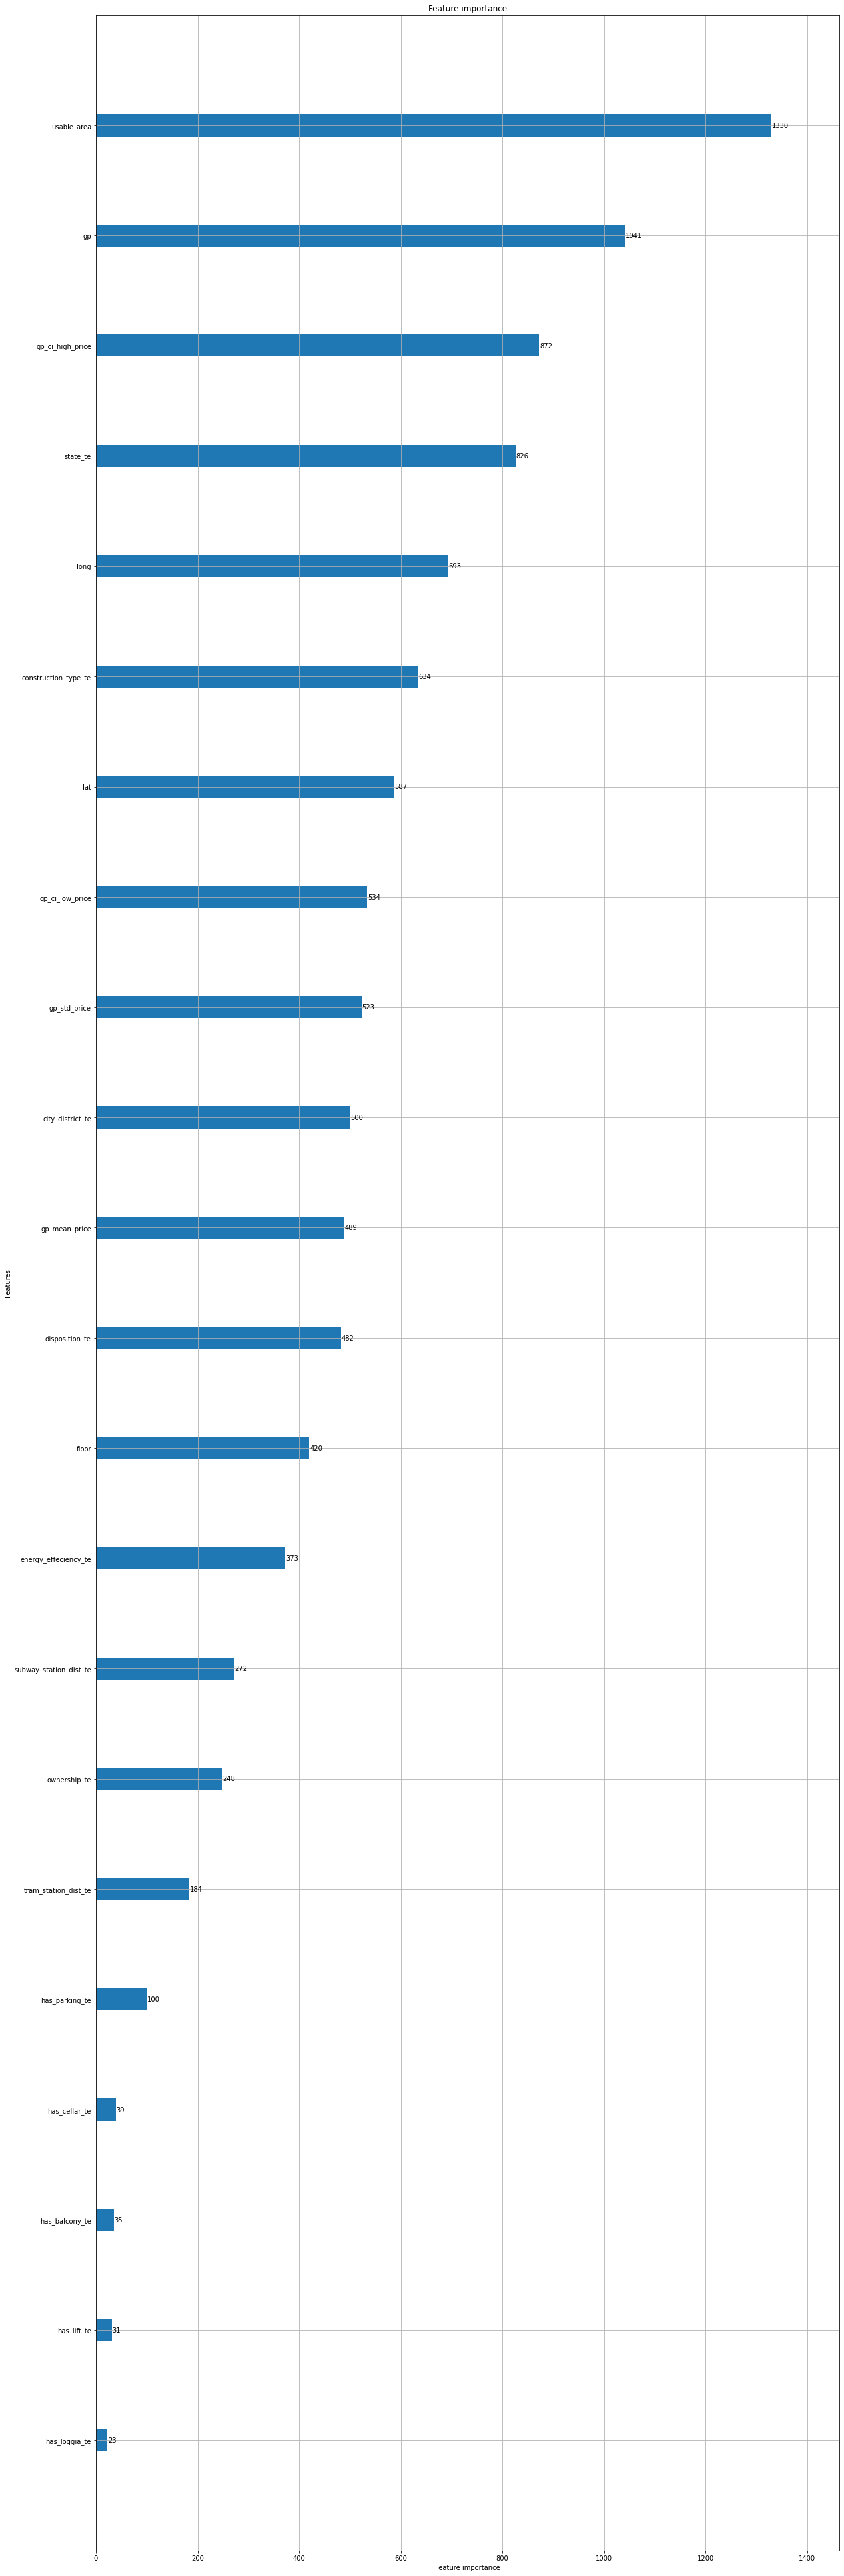

In [ ]:
ax = gp_importance(model)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

In [ ]:
only_gp[:-1]

['gp_ci_high_price', 'gp_ci_low_price', 'gp_mean_price', 'gp_std_price']

# Gaussian process

In [ ]:
gp = GaussianProcessRegressor(kernel= Matern(length_scale=0.1, nu=0.01),
                              normalize_y= True)
gp.fit(X_train[['long', 'lat']], y_train['price_m2'])

KeyboardInterrupt: ignored

In [ ]:
gp_predicted = gp.predict(X_test[['long', 'lat']])
gp_predicted2 = gp.predict(X_test[['long', 'lat']])
import numpy as np

response = 'price_m2'
print("The model training score is " , gp.score(X_train, y_train[response]))
print("The model testing score is " , gp.score(X_test, y_test[response]))
print("The model train mean absolute error is ", mean_absolute_error(y_train[response], gp_predicted2))
print("The model testing mean absolute error is ", mean_absolute_error(y_test[response], gp_predicted))
print("The model train mean squared error is ", np.sqrt(mean_squared_error(y_train[response], gp_predicted2)))
print("The model testing mean squared error is ", np.sqrt(mean_squared_error(y_test[response], gp_predicted)))
print("The model max error is ", max_error(y_test[response], gp_predicted))
print("The model median absolute error is ", median_absolute_error(y_test[response],gp_predicted))

# XGBOOST

In [172]:
# squared_error  
# TODO it uses squared error we need to use absolute error but colab does not have it

response = 'price'

mean = y_train[response].mean()
std = y_train[response].std()

y_train['response'] = (y_train[response] - mean) / std
y_test['response'] = (y_test[response] - mean) / std

model = XGBRegressor(n_estimators = 1500,
                     learning_rate=0.08999, 
                     colsample_bytree=0.99,
                     colsample_bynode=0.60,
                     objective='reg:squarederror',#'reg:pseudohubererror',
                     eval_metric=mean_absolute_error,
                     max_depth=4,
                     tree_method='hist',
                     enable_categorical=True,
                     #subsample=0.9,
                     random_state=42, silent=True, booster='gbtree',
                     
            early_stopping_rounds=20)

model.fit(X_train, y_train['response'], eval_set=[(X_test, y_test['response'])])

# make predictions for test data
y_pred = model.predict(X_test)
y_pred2 = model.predict(X_train)

#y_pred2 = X_test['usable_area'] * y_pred

print("The model training score is " , model.score(X_train, y_train['response']))
print("The model testing score is " , model.score(X_test, y_test['response']))
print("The model train mean absolute error is ", mean_absolute_error(y_train['response'], y_pred2))
print("The model testing mean absolute error is ", mean_absolute_error(y_test['response'], y_pred))
print("The model train mean squared error is ", np.sqrt(mean_squared_error(y_train['response'], y_pred2)))
print("The model testing mean squared error is ", np.sqrt(mean_squared_error(y_test['response'], y_pred)))
print("The model max error is ", max_error(y_test['response'], y_pred))
print("The model median absolute error is ", median_absolute_error(y_test['response'], y_pred))

[21:11:35] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.03887	validation_0-mean_absolute_error:0.82541
[1]	validation_0-rmse:0.96727	validation_0-mean_absolute_error:0.76213
[2]	validation_0-rmse:0.90634	validation_0-mean_absolute_error:0.70529
[3]	validation_0-rmse:0.84861	validation_0-mean_absolute_error:0.65394
[4]	validation_0-rmse:0.79550	validation_0-mean_absolute_error:0.60735
[5]	validation_0-rmse:0.74804	validation_0-mean_absolute_error:0.56689
[6]	validation_0-rmse:0.70839	validation_0-mean_absolute_error:0.52930
[7]	validation_0-rmse:0.67292	validation_0-mean_absolute_error:0.49621
[8]	validation_0-rmse:0.64373	validation_0-mean_absolute_error:0.46709
[9]	

In [171]:
yy = (y_pred * std) + mean
print(mean_absolute_error(y_test['price'], yy))

1142073.526388889


# Results

- Target encod + base - dist = baseline
mae = 1122
r2 87%
- baseline + dist ord mae = 1093
r2 87.8%
- baseline + dist num  mae = 1117
r2 87
- baseline + dist (tram, subway), mae = 1115 r86.4

- baseline + one hot dist mae = 1179 r2=83
- baseline + te dist mae = 1093 r2 = 87.8
- one hot + te dist mae = 1098 r2=88.6
- only te (with te dist and with has_te) + only_has mae = 1086 r2=88.9% -> **BEST**
- only te (with dist but not has_te) + only_has mae 1118 86.9 

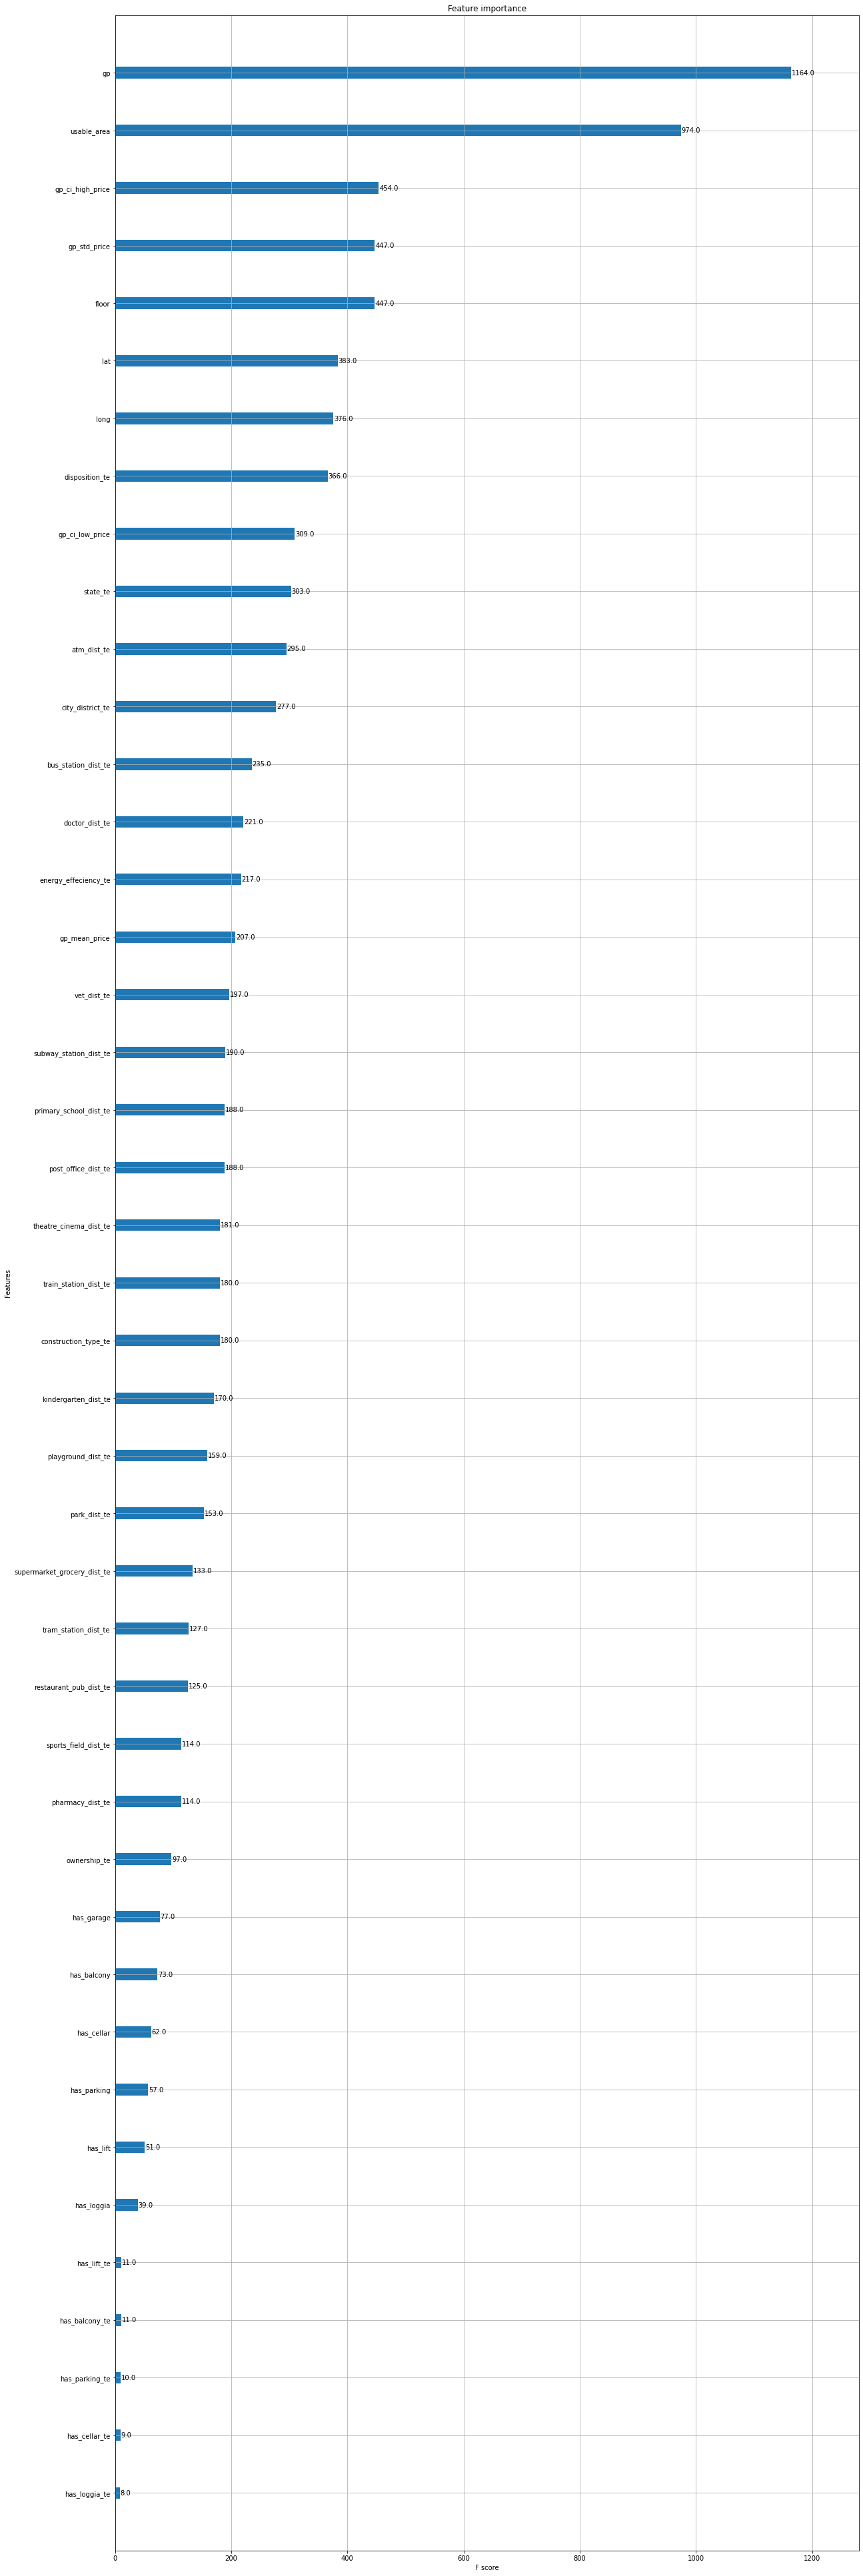

In [138]:
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

In [ ]:
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_error(y_test, X_test['usable_area'] * X_test['gp_mean_price']))

1206336.948391421
1792763.081191732


In [ ]:
mean_cena = (X_test['gp_mean_price']).to_numpy()*0.01 + y_pred*0.99
print(mean_absolute_error(y_test['price_m2'], mean_cena))

14982.735156202345


In [ ]:
print(mean_absolute_error(y_test, mean_cena))

1195684.3216524199


In [ ]:
np.where(y_pred < y_test['price_m2'].to_numpy().flatten(), 1, 0).sum()

686

In [ ]:
df2.iloc[np.where(y_pred > y_test['price_m2'].to_numpy().flatten())[0]]['price'].describe()

count    7.460000e+02
mean     9.212207e+06
std      6.989218e+06
min      2.250000e+06
25%      5.700000e+06
50%      7.236000e+06
75%      1.093750e+07
max      1.290000e+08
Name: price, dtype: float64

In [ ]:
y_test.shape

(1492, 1)

In [ ]:
y_pred

array([ 7772109.5,  6378095.5, 10913351. , ...,  6711773.5, 10301290. ,
        8109418.5], dtype=float32)

In [ ]:
X_test.iloc[0:1]

,disposition_1_plus_1,disposition_1_plus_kk,disposition_2_plus_1,disposition_2_plus_kk,disposition_3_plus_1,disposition_3_plus_kk,disposition_4_plus_1,disposition_4_plus_kk,disposition_5_plus_1,disposition_5_plus_kk,disposition_6_plus_kk,disposition_6_pokojů_a_více,disposition_atypické,disposition_unknown,energy_effeciency_A,energy_effeciency_B,energy_effeciency_C,energy_effeciency_D,energy_effeciency_E,energy_effeciency_F,energy_effeciency_G,energy_effeciency_unknown,gp_ci_high_price,gp_ci_low_price,gp_mean_price,gp_std_price,lat,long,ownership_Družstevní,ownership_Osobní,ownership_Státní_obecní,ownership_unknown,usable_area
5672,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,194760.035596,70621.933102,132690.984349,31034.525623,50.101878,14.450002,0.0,1.0,0.0,0.0,54.0


In [ ]:
df_final.iloc[5672:5673]

,disposition_1_plus_1,disposition_1_plus_kk,disposition_2_plus_1,disposition_2_plus_kk,disposition_3_plus_1,disposition_3_plus_kk,disposition_4_plus_1,disposition_4_plus_kk,disposition_5_plus_1,disposition_5_plus_kk,disposition_6_plus_kk,disposition_6_pokojů_a_více,disposition_atypické,disposition_unknown,energy_effeciency_A,energy_effeciency_B,energy_effeciency_C,energy_effeciency_D,energy_effeciency_E,energy_effeciency_F,energy_effeciency_G,energy_effeciency_unknown,gp_ci_high_price,gp_ci_low_price,gp_mean_price,gp_std_price,lat,long,ownership_Družstevní,ownership_Osobní,ownership_Státní_obecní,ownership_unknown,price,usable_area
5672,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,194760.035596,70621.933102,132690.984349,31034.525623,50.101878,14.450002,0.0,1.0,0.0,0.0,6735950.0,54.0


In [ ]:
dd = X_test.iloc[0:3].copy()

In [ ]:
dd['daily_noise'] = 50.
#dd['state_Špatný'] = 1.
#dd['ownership_Osobní'] = 0.

In [ ]:
dd

,city_district_te,construction_type_te,disposition_te,energy_effeciency_te,floor,gp_ci_high_price,gp_ci_low_price,gp_mean_price,gp_std_price,has_balcony_te,has_cellar_te,has_garden_te,has_lift_te,has_loggia_te,has_parking_te,lat,long,ownership_te,state_te,subway_station_dist_te,tram_station_dist_te,usable_area
5782,187935.709541,135539.244823,151339.092659,116853.682567,1.0,209840.985568,85679.606242,147760.295905,31040.344831,False,False,False,False,False,False,50.077816,14.422916,133345.218782,126022.393676,3.0,2.0,21.0


In [ ]:
model.predict(dd)

array([4222046.5, 4503419.5, 6450596.5], dtype=float32)

In [ ]:
print(model.predict(X_test.iloc[0:3]))
print(y_test[0:3])
print(X_test.usable_area.iloc[0:1])#
#print(X_test['gp'].iloc[0:1])

gp_weight = 1 / X_test['usable_area']
print(gp_weight)

[194562.11 147979.12 123670.79]
          price  price_m2    price_diff  price_diff_m2
5782  3990000.0  190000.0 -8.870338e+05  -42239.704095
2184  5100000.0  159375.0 -1.282972e+06  -40092.874772
1766  6615000.0  135000.0 -9.568763e+05  -19528.087724
5782    21.0
Name: usable_area, dtype: float64
5782    0.047619
2184    0.031250
1766    0.020408
5173    0.017857
4774    0.007143
          ...   
3447    0.022727
2035    0.007407
6361    0.029412
6185    0.009091
1428    0.010101
Name: usable_area, Length: 1440, dtype: float64


In [ ]:
pred = y_pred * X_test['usable_area'].to_numpy()

In [ ]:
print(mean_absolute_error(y_test['price'], pred))

1144099.1674696181


In [ ]:
print(mean_absolute_error(y_test['price'], (X_test['gp'].to_numpy() * gp_weight) + (y_pred * (1-gp_weight))))

1204029.436325795


In [ ]:
X['gp_mean_price'].max()

162801.44840679644

In [ ]:
#@title XGBQuantile Class
class XGBQuantile(XGBRegressor):
  def __init__(self,quant_alpha=0.5,quant_delta = 1.0,quant_thres=1.0,
               quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, colsample_bynode=1, gamma=0, 
               learning_rate=0.1, max_delta_step=0,max_depth=3,
               min_child_weight=1, missing=1, n_estimators=100,
                n_jobs=1, 
               #nthread=None, 
               objective='reg:linear',
                eval_metric=None, early_stopping_rounds=None,
                random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
               #seed=None,
               #silent=True, 
               subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster,
                     colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, 
       colsample_bynode=colsample_bynode,
        gamma=gamma, learning_rate=learning_rate,
         max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight,
        #missing=missing,
         n_estimators=n_estimators,
       n_jobs= n_jobs, 
       #nthread=nthread, 
       objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, 
       #seed=seed,
       #silent=silent,
        subsample=subsample, 
       early_stopping_rounds=early_stopping_rounds,
       eval_metric=eval_metric)
    
    self.test = None
  
  def fit(self, X, y 
          #,eval_set=None
          ):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,
                                         alpha = self.quant_alpha,
                                         delta = self.quant_delta,
                                         threshold = self.quant_thres,
                                         var = self.quant_var
                                         ) )
    super().fit(X,y
                #, eval_set=eval_set
                )
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    #print(x[0:2])
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    #print(x.shape)
    grad = (x < (alpha-1.0) * delta) * (1.0 - alpha) - \
            ((x >= (alpha-1.0) * delta) & (x < alpha * delta)) * x/delta -\
             alpha * (x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )
    
    return np.array(split_gain)

In [ ]:
model_upper = XGBQuantile(quant_alpha = 0.95, quant_delta= 1.0,
                    quant_thres = 1.0 ,quant_var=1.0,
                    n_estimators = 250,
                     learning_rate=0.08999, 
                     colsample_bytree=0.99,
                     colsample_bynode=0.90,
                     #objective='reg:squarederror',
                     #eval_metric=mean_absolute_error,
                     max_depth=4,
                     #tree_method='hist',
                     #enable_categorical=True,
                     #subsample=0.9,
                     random_state=42,
                     #silent=True, 
                    booster='gbtree',
                     
            #early_stopping_rounds=20
            )

model_lower = XGBQuantile(quant_alpha = 0.05, quant_delta= 1.0,
                    quant_thres = 1.0 ,quant_var=1.0,
                    n_estimators = 250,
                     learning_rate=0.08999, 
                     colsample_bytree=0.99,
                     colsample_bynode=0.90,
                     #objective='reg:squarederror',
                     #eval_metric=mean_absolute_error,
                     max_depth=4,
                     #tree_method='hist',
                     #enable_categorical=True,
                     #subsample=0.9,
                     random_state=42,
                     #silent=True, 
                    booster='gbtree',
                     
            #early_stopping_rounds=20
            )

model_median = XGBQuantile(quant_alpha = 0.5, quant_delta= 1.0,
                    quant_thres = 1.0 ,quant_var=1.0,
                    n_estimators = 250,
                     learning_rate=0.08999, 
                     colsample_bytree=0.99,
                     colsample_bynode=0.90,
                     #objective='reg:squarederror',
                     #eval_metric=mean_absolute_error,
                     max_depth=4,
                     #tree_method='hist',
                     #enable_categorical=True,
                     #subsample=0.9,
                     random_state=42,
                     #silent=True, 
                    booster='gbtree',
                     
            #early_stopping_rounds=20
            )

response = 'price'
model_median.fit(X_train, y_train['response']
          #, eval_set=[(X_test, y_test[response])]
          )
model_lower.fit(X_train, y_train['response']
          #, eval_set=[(X_test, y_test[response])]
          )
model_upper.fit(X_train, y_train['response']
          #, eval_set=[(X_test, y_test[response])]
          )

# make predictions for test data
y_pred = model_median.predict(X_test)
y_pred2 = model_median.predict(X_train)


#print("The model training score is " , model_median.score(X_train, y_train['response']))
#print("The model testing score is " , model_median.score(X_test, y_test['response']))
print("The model train mean absolute error is ", mean_absolute_error(y_train['response'], y_pred2))
print("The model testing mean absolute error is ", mean_absolute_error(y_test['response'], y_pred))
print("The model train mean squared error is ", np.sqrt(mean_squared_error(y_train['response'], y_pred2)))
print("The model testing mean squared error is ", np.sqrt(mean_squared_error(y_test['response'], y_pred)))
print("The model max error is ", max_error(y_test['response'], y_pred))
print("The model median absolute error is ", median_absolute_error(y_test['response'], y_pred))

[19:51:16] WARNING: ../src/learner.cc:627: 
Parameters: { "quant_alpha", "quant_delta", "quant_thres", "quant_var" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:51:22] WARNING: ../src/learner.cc:627: 
Parameters: { "quant_alpha", "quant_delta", "quant_thres", "quant_var" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:51:26] WARNING: ../src/learner.cc:627: 
Parameters: { "quant_alpha", "quant_delta", "quant_thres", "quant_var" } might not be used.

  This could be a false alarm, with some parameters g

In [ ]:
out_df = pd.DataFrame(data={'lower_ci_price': (model_lower.predict(X_test.iloc[0:10]) * std) + mean,
                            'median_price': (model_median.predict(X_test.iloc[0:10]) * std) + mean,
                            'mean_price': (model.predict(X_test.iloc[0:10]) * std) + mean,
                            'upper_ci_price': (model_upper.predict(X_test.iloc[0:10]) * std) + mean,
                            'real_prices': y_test[0:10]["price"].values})

In [ ]:
out_df

,lower_ci_price,median_price,mean_price,upper_ci_price,real_prices
0,3649380.0,3613176.0,3996294.5,8306197.0,3990000.0
1,4915400.5,3425476.5,4568319.5,5681469.0,5100000.0
2,5777624.5,6448031.0,6280766.5,6527247.0,6615000.0
3,6137112.0,6207158.5,6606193.5,6752422.5,6499900.0
4,12093038.0,16474516.0,14493984.0,18824020.0,10499000.0
5,1730590.0,2590918.5,2909842.5,7235365.0,2980000.0
6,2373294.5,4718053.0,1753144.0,5293460.0,1599000.0
7,5830873.0,5835802.0,6338464.0,5968025.0,5950000.0
8,12722473.0,14522596.0,12884185.0,16720145.0,14500000.0
9,8953246.0,11567336.0,10304379.0,15083360.0,8443855.0


# TODO perform quantile regression

- https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b

- https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

- https://gist.github.com/Nikolay-Lysenko/06769d701c1d9c9acb9a66f2f9d7a6c7

- https://colab.research.google.com/github/benoitdescamps/benoit-descamps-blogs/blob/master/notebooks/quantile_xgb/xgboost_quantile_regression.ipynb#scrollTo=Rb4sKEKa9EkN